In [58]:
"""
Manuscript figures
"""

import os, sys
import geopandas as gpd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches

from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import MinMaxScaler

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')
icsdir = os.path.join(maindir, 'ics209-plus-fired/data/')

print("Ready !")

Ready !


In [2]:
# load fire perimeter data
fp = os.path.join(projdir,'data/spatial/mod/NIFC/nifc-ics_2018_to_2023-aspen.gpkg')
fires = gpd.read_file(fp)
fires.columns

Index(['NIFC_ID', 'NIFC_NAME', 'NIFC_ACRES', 'FINAL_ACRES', 'pct_cover',
       'INCIDENT_ID', 'INCIDENT_NAME', 'START_YEAR', 'CAUSE', 'DISCOVERY_DATE',
       'DISCOVERY_DOY', 'WF_CESSATION_DATE', 'WF_CESSATION_DOY',
       'STR_DESTROYED_TOTAL', 'STR_DAMAGED_TOTAL', 'STR_THREATENED_MAX',
       'EVACUATION_REPORTED', 'PEAK_EVACUATIONS', 'WF_PEAK_AERIAL',
       'WF_PEAK_PERSONNEL', 'na_l3name', 'geometry'],
      dtype='object')

In [11]:
# load the frp grid
fp = os.path.join(projdir,f'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_aspenfires_pixar_gridstats.gpkg')
grid = gpd.read_file(fp)
grid.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'frp_csum',
       'frp_max', 'frp_min', 'frp_p90', 'frp_first', 'day_max_frp',
       'dt_max_frp', 'first_obs_date', 'last_obs_date', 'day_count',
       'night_count', 'frp_max_day', 'frp_max_night', 'frp_p90_day',
       'frp_p90_night', 'frp_first_day', 'frp_first_night', 'Fire_ID',
       'Fire_Name', 'geometry'],
      dtype='object')

In [3]:
fp = os.path.join(projdir,'data/spatial/raw/boundaries/na_cec_eco_l3_west.gpkg')
ecol3 = gpd.read_file(fp)
ecol3 = ecol3[['NA_L3NAME','NA_L3CODE','geometry']].rename(columns={'NA_L3NAME': 'na_l3name', 'NA_L3CODE': 'na_l3code'})
ecol3.columns

Index(['na_l3name', 'na_l3code', 'geometry'], dtype='object')

In [ ]:
# Figure 1A. Map of the Southern Rockies

count        58.000000
mean       9627.908349
std       23463.171995
min          16.972531
25%         293.395327
50%         990.699656
75%        5229.909947
max      121321.868124
Name: FINAL_HA, dtype: float64


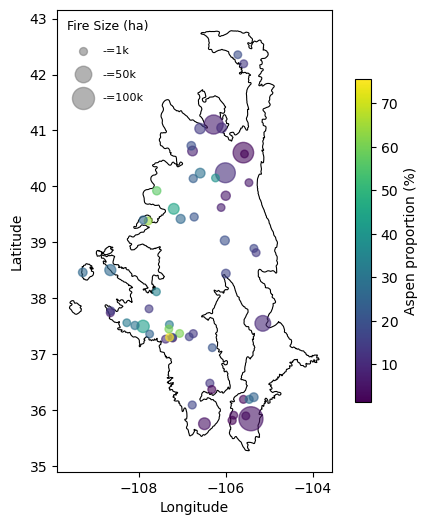

In [105]:
# Generate centroids
fires_ = fires[fires['NIFC_ID'].isin(grid['Fire_ID'].unique())]
fires_['NIFC_ACRES'] = pd.to_numeric(fires_['NIFC_ACRES'], errors='coerce')
fires_['FINAL_KM2'] = fires_['NIFC_ACRES'] * 0.00404686
fires_['FINAL_HA'] = fires_['NIFC_ACRES']* 0.404686
print(fires_['FINAL_HA'].describe())

# Get the centroid of fires
centroid = fires_.copy()
centroid['geometry'] = centroid.geometry.centroid
centroid['aspen_size'] = centroid['pct_cover'] * 5  

# # do some scaling (area weighted aspen cover)
# scaler = MinMaxScaler(feature_range=(0, 100))  # Normalize to 0–100
# centroid['pct_cover_wt'] = centroid['pct_cover'] * centroid['FINAL_HA']  # Weighted by fire size
# centroid['pct_cover_wt_nm'] = scaler.fit_transform(centroid[['pct_cover_wt']])

scaler = MinMaxScaler(feature_range=(10, 100))  # Marker sizes between 10 and 200
centroid['fire_size'] = scaler.fit_transform(centroid[['FINAL_HA']]) * 3

# subset to SRM
centroid_srm = centroid[centroid['na_l3name'] == 'Southern Rockies']
ecol3_srm = ecol3[ecol3['na_l3name'] == 'Southern Rockies']

# Ensure the same projection
centroid_srm = centroid_srm.to_crs(4326)
ecol3_srm = ecol3_srm.to_crs(4326)

# plot it
fig, ax = plt.subplots(figsize=(6, 6))

ecol3_srm.plot(ax=ax, edgecolor='black', linewidth=0.8, color='none')

centroid_srm.plot(
    ax=ax, 
    markersize=centroid_srm['fire_size'],  # Use normalized marker size
    column='pct_cover', cmap='viridis', 
    legend=False, alpha=0.6)

# Add colorbar for aspen percent cover
norm = mcolors.Normalize(vmin=centroid_srm['pct_cover'].min(), vmax=centroid_srm['pct_cover'].max())
sm = ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label('Aspen proportion (%)')

# Create a custom legend for fire size
# Create legend sizes for fire size (in hectares)
legend_sizes_ha = [1000, 50000, 100000]  # Example fire sizes in hectares
legend_scaled_sizes = scaler.transform([[size] for size in legend_sizes_ha]).flatten() * 3
legend_labels = [f'-={int(size / 1000)}k' for size in legend_sizes_ha]

# Create legend handles using the correctly scaled sizes
legend_handles = [
    plt.scatter([], [], s=size, color='gray', alpha=0.6, label=label)
    for size, label in zip(legend_scaled_sizes, legend_labels)
]

# Add the legend to the map
ax.legend(
    handles=legend_handles, loc='upper left', 
    title='Fire Size (ha)', frameon=False, fontsize=8, title_fontsize=9, 
    handletextpad=0.8,  # Space between markers and labels
    labelspacing=1.2    # Vertical space between legend items
)

# Labels and saving
plt.xlabel('Longitude', size=10)
plt.ylabel('Latitude', size=10)

# Save the map
plt.savefig(os.path.join(projdir, 'figures/Figure1_Aspen-Fires_NIFC-SRM.png'), dpi=300, bbox_inches='tight')

plt.show()

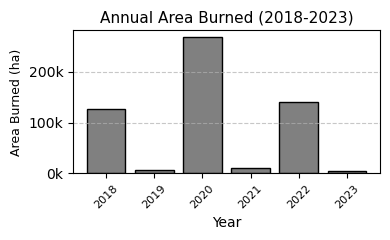

In [46]:
# plot the annual area burned
burned_area = fires_.groupby('START_YEAR')['FINAL_HA'].sum().reset_index()

# set up the axis formatter
def format_thousands(x, pos):
    """Format y-axis labels to display values in 'k' for thousands."""
    return f'{int(x / 1000)}k'

formatter = FuncFormatter(format_thousands)

# Plot the results
plt.figure(figsize=(4, 2.5))
plt.bar(burned_area['START_YEAR'], burned_area['FINAL_HA'], color='grey', edgecolor='black')
plt.title('Annual Area Burned (2018-2023)', fontsize=11)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Area Burned (ha)', fontsize=9)
plt.xticks(burned_area['START_YEAR'], rotation=45, size=8)

# Apply custom formatting to y-axis
plt.gca().yaxis.set_major_formatter(formatter)
# plt.ylim(10000, None)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig(os.path.join(projdir, 'figures/Figure1b_Aspen-Fires_NIFC-SRM_annualBurnedArea.png'), dpi=300, bbox_inches='tight')

plt.show()

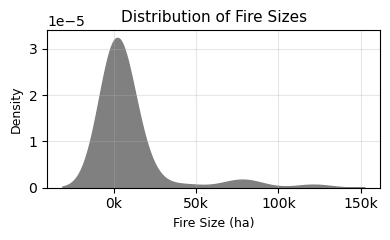

In [55]:
# plot the density distribution of fire size
plt.figure(figsize=(4, 2.5))
sns.kdeplot(fires_['FINAL_HA'], fill=True, color='grey', alpha=1)
plt.title('Distribution of Fire Sizes', fontsize=11)
plt.xlabel('Fire Size (ha)', fontsize=9)
plt.ylabel('Density', fontsize=9)

plt.gca().xaxis.set_major_formatter(formatter)

plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig(os.path.join(projdir, 'figures/Figure1b_Aspen-Fires_NIFC-SRM_fireSize.png'), dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Figure 2. Conceptual workflow for VIIRS AFD.

In [106]:
grid.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'frp_csum',
       'frp_max', 'frp_min', 'frp_p90', 'frp_first', 'day_max_frp',
       'dt_max_frp', 'first_obs_date', 'last_obs_date', 'day_count',
       'night_count', 'frp_max_day', 'frp_max_night', 'frp_p90_day',
       'frp_p90_night', 'frp_first_day', 'frp_first_night', 'Fire_ID',
       'Fire_Name', 'geometry'],
      dtype='object')

In [109]:
# subset to an example fire (Williams Fork)
fire = grid[grid['Fire_Name'] == 'WILLIAMS FORK']

In [110]:
# supplemental figure 1: pixel ground area size distribution
fp = os.path.join(projdir,f'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_aspenfires_pixar_nd.gpkg')
pix_area = gpd.read_file(fp)
pix_area.columns

Index(['longitude', 'latitude', 'fire_mask', 'confidence', 'frp', 't4', 't5',
       'm13', 'acq_date', 'acq_time', 'daynight', 'satellite', 'short_name',
       'granule_id', 'geo_id', 'sample', 'along_scan', 'along_track',
       'scan_angle', 'pix_area', 'afdID', 'Fire_ID', 'Fire_Name', 'NIFC_ACRES',
       'FINAL_ACRES', 'pct_cover', 'INCIDENT_ID', 'INCIDENT_NAME',
       'START_YEAR', 'CAUSE', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'WF_CESSATION_DATE', 'WF_CESSATION_DOY', 'STR_DESTROYED_TOTAL',
       'STR_DAMAGED_TOTAL', 'STR_THREATENED_MAX', 'EVACUATION_REPORTED',
       'PEAK_EVACUATIONS', 'WF_PEAK_AERIAL', 'WF_PEAK_PERSONNEL', 'na_l3name',
       'acq_month', 'acq_year', 'count', 'obs_id', 'acq_datetime', 'frp_wkm2',
       'geometry'],
      dtype='object')

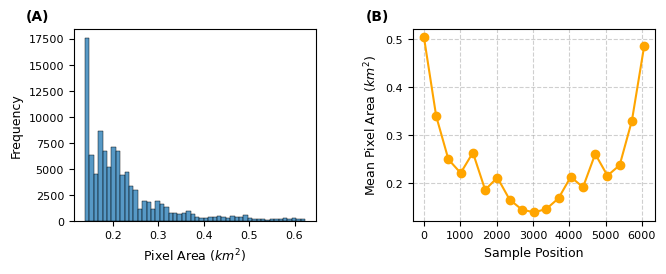

In [136]:
# Bin the sample positions into intervals
bin_edges = np.linspace(pix_area['sample'].min(), pix_area['sample'].max(), 20)  # Create 20 bins
pix_area['sample_bin'] = pd.cut(pix_area['sample'], bins=bin_edges, labels=bin_edges[:-1])

# Calculate mean pixel area for each bin
sample_summary = pix_area.groupby('sample_bin')['pix_area'].mean().reset_index()
sample_summary['sample_bin'] = sample_summary['sample_bin'].astype(float)  # Convert bin labels to float

# Create the figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(7.5, 2.5), constrained_layout=False)
fig.subplots_adjust(hspace=0.1, wspace=0.4)  

# ======= Left Plot: Histogram =======
sns.histplot(
    data=pix_area, 
    x="pix_area", 
    bins=50,  # Fine-grained bins for clarity
    color="#1f77b4", 
    kde=False, 
    ax=axes[0]
)

axes[0].set_xlabel("Pixel Area ($km^2$)", fontsize=9)
axes[0].set_ylabel("Frequency", fontsize=9)

# ======= Right Plot: Line Plot =======
axes[1].plot(
    sample_summary['sample_bin'], 
    sample_summary['pix_area'], 
    marker='o', color='orange', label="Mean Pixel Area"
)
axes[1].set_xlabel("Sample Position", fontsize=9)
axes[1].set_ylabel("Mean Pixel Area ($km^2$)", fontsize=9)
axes[0].tick_params(axis='both', which='major', labelsize=8)  # Change 10 to desired font size
axes[1].tick_params(axis='both', which='major', labelsize=8)

axes[1].grid(True, linestyle='--', alpha=0.6)

axes[0].text(-0.1, 1.1, "(A)", transform=axes[0].transAxes, fontsize=10, fontweight="bold", va="top", ha="right")
axes[1].text(-0.1, 1.1, "(B)", transform=axes[1].transAxes, fontsize=10, fontweight="bold", va="top", ha="right")

# Save the plot
out_plot = os.path.join(projdir, 'figures/FigureS1_PixelGroundArea_Distribution.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

# Show the plots
plt.show()